In [1]:
%load_ext autoreload
%autoreload 2

import logging
import sys
from typing import List

import numpy as np
import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import core.plotting as coplotti
import core.signal_processing as csigproc
import core.statistics as costatis
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint

/app/amp/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-4419fb36-2ea3-4401-98f3-e07ddb921143.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.8.0' != container_version='1.6.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmampTask5348_Get_yahoo_data_2'
  hash='cd1a3c0b1'
  # Last commits:
    * cd1a3c0b1 Paul     Checkpoint                                                        (   3 hours ago) Thu Sep 28 16:18:53 2023  (HEAD -> CmampTask5348_Get_yahoo_data_2, origin/CmampTask5348_Get_yahoo_data_2)
    * 5e25fd48b Paul     Checkpoint                                                        (  22 hours ago) Wed Sep 27 21:44:40 2023           
 

# Load package `yahoo_fin`

In [3]:
# https://theautomatic.net/2018/01/25/coding-yahoo_fin-package/
!sudo {sys.executable} -m pip install --upgrade yahoo_fin
import yahoo_fin.stock_info as si

Requirement already up-to-date: yahoo_fin in /venv/lib/python3.8/site-packages (0.8.9.1)


In [4]:
historical_data = si.get_data("amzn", start_date = "01/01/2017", end_date = "01/31/2017")

In [5]:
historical_data

,open,high,low,close,adjclose,volume,ticker
2017-01-03,37.896000,37.938000,37.384998,37.683498,37.683498,70422000,AMZN
2017-01-04,37.919498,37.984001,37.709999,37.859001,37.859001,50210000,AMZN
2017-01-05,38.077499,39.119999,38.013000,39.022499,39.022499,116602000,AMZN
2017-01-06,39.118000,39.972000,38.924000,39.799500,39.799500,119724000,AMZN
2017-01-09,39.900002,40.088501,39.588501,39.846001,39.846001,68922000,AMZN
2017-01-10,39.830002,39.900002,39.477001,39.794998,39.794998,51168000,AMZN
2017-01-11,39.682999,39.974998,39.475498,39.951000,39.951000,59856000,AMZN
2017-01-12,40.015499,40.706501,39.974998,40.681999,40.681999,97478000,AMZN
2017-01-13,40.716000,41.082500,40.570000,40.856998,40.856998,75838000,AMZN
2017-01-17,40.785000,40.799999,40.172001,40.486000,40.486000,73410000,AMZN


# Define universe and get adjusted close prices

In [6]:
tickers = [
#    "IAU", # iShares Gold Trust
    "BTC-USD",
    "SPY",
#     "USIG", # iShares Broad USD Investment Grade Corporate Bond ETF
#     "USRT", # iShares Core US REIT ETF
#     "GSG", # GSCI Commodity
]

In [7]:
sector_etfs = [
    "XLC", # Communication
    "XLY", # Consumer Discretionary
    "XLP", # Consumer Staples
    "XLE", # Energy
    "XLF", # Financial
    "XLV", # Health Care
    "XLI", # Industrial
    "XLB", # Materials
    "XLRE", # Real Estate
    "XLK", # Technology
    "XLU", # Utilities
]

In [8]:
start_date = "2015/01/01"
end_date = "2023/08/31"
resampling_freq = "1B"
num_points_rolling_vol = 40

In [9]:
def get_adj_close(tickers: List[str], start_date: str, end_date: str) -> pd.Series:
    ticker_data = []
    for ticker in tickers:
        data = si.get_data(ticker, start_date=start_date, end_date=end_date)
        data = data["adjclose"].rename(ticker)
        ticker_data.append(data)
    df = pd.concat(ticker_data, axis=1)
    return df

In [10]:
df = get_adj_close(tickers, start_date, end_date)
df.head()

,BTC-USD,SPY
2015-01-01,314.248993,NaN
2015-01-02,315.032013,175.515488
2015-01-03,281.082001,NaN
2015-01-04,264.195007,NaN
2015-01-05,274.473999,172.345779


In [11]:
color_dict = {
    "SPY": "r",
    "BTC-USD": "y",
}

In [12]:
resampled_adj_close = df.resample(resampling_freq).last() 

<Axes: >

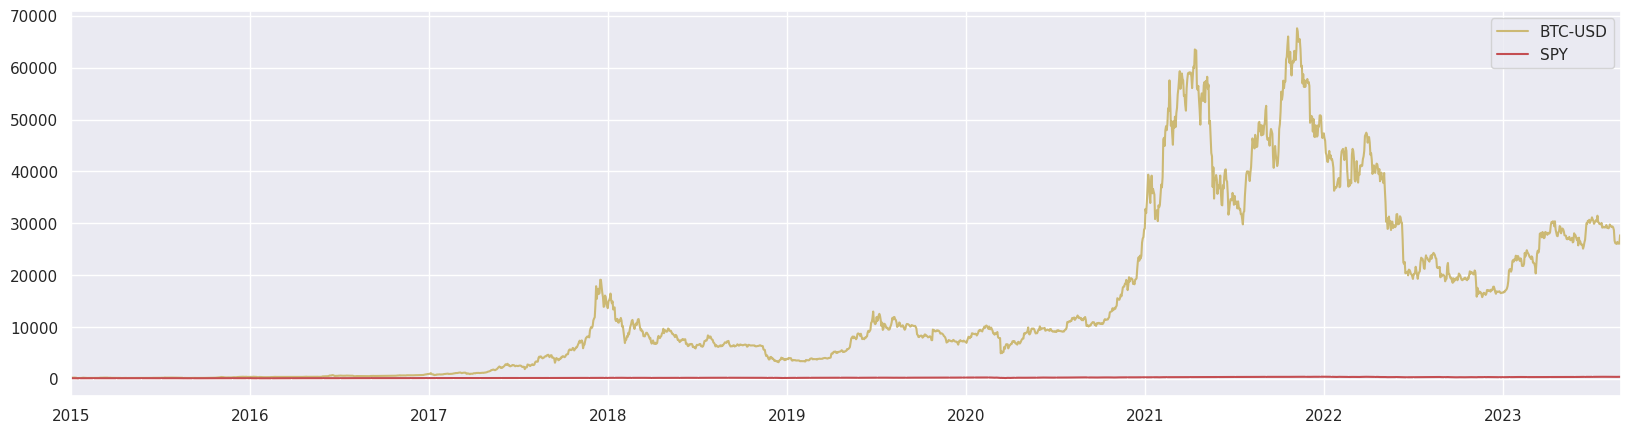

In [13]:
resampled_adj_close.plot(color=color_dict)

<Axes: title={'center': 'BTC-USD'}, xlabel='date', ylabel='dollars'>

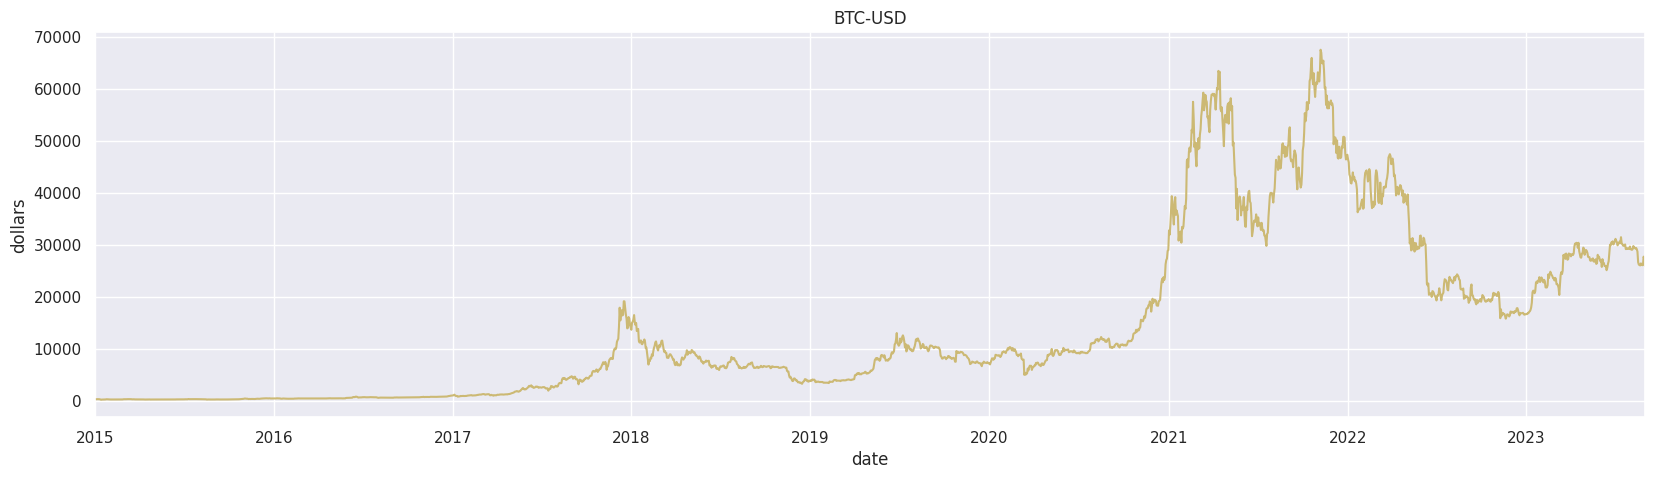

In [14]:
resampled_adj_close["BTC-USD"].plot(
    title="BTC-USD",
    ylabel="dollars",
    xlabel="date",
    color=color_dict,
)

<Axes: title={'center': 'SPY'}, xlabel='date', ylabel='dollars'>

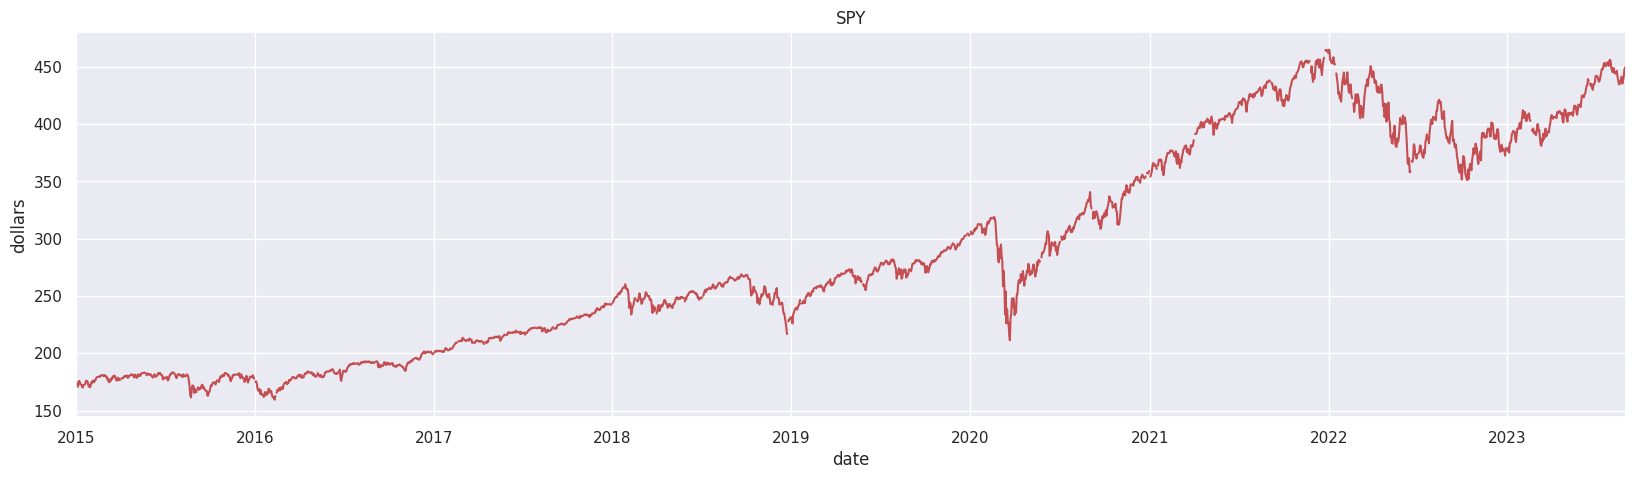

In [15]:
resampled_adj_close["SPY"].plot(
    title="SPY",
    ylabel="dollars",
    xlabel="date",
    color=color_dict,
)

In [16]:
resampled_adj_close.resample("Y").first()

,BTC-USD,SPY
2015-12-31,314.248993,175.515488
2016-12-31,430.010986,175.291748
2017-12-31,1021.750000,200.629654
2018-12-31,13657.200195,244.057755
2019-12-31,3843.520020,231.492233
2020-12-31,7200.174316,306.295227
2021-12-31,32782.023438,354.197388
2022-12-31,46458.117188,464.923370
2023-12-31,16688.470703,376.639587


## Compute returns and volatility

In [17]:
first_price = resampled_adj_close.dropna().iloc[0]
first_date = resampled_adj_close.index[0]
last_price = resampled_adj_close.dropna().iloc[-1]
last_date = resampled_adj_close.index[-1]
period_pct_return = last_price / first_price - 1
period = last_date - first_date

In [18]:
last_price

BTC-USD    27297.265625
SPY          449.424744
Name: 2023-08-30 00:00:00, dtype: float64

In [19]:
last_date

Timestamp('2023-08-31 00:00:00', freq='B')

In [20]:
period_pct_return

BTC-USD    102.322413
SPY          1.560599
dtype: float64

<Axes: title={'center': 'percent return'}, xlabel='date', ylabel='% daily return'>

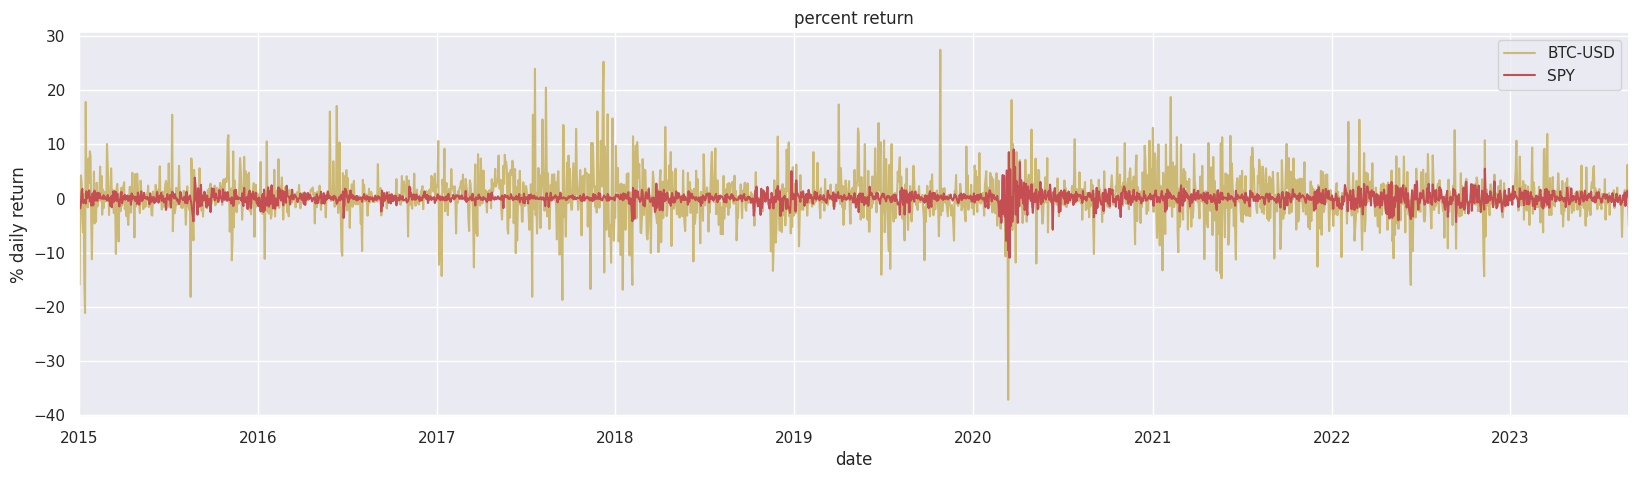

In [21]:
# Plot daily returns as a percentage (including multiplication by 100).
pct_return = resampled_adj_close.pct_change()
(100 * pct_return).plot(
    title="percent return",
    ylabel="% daily return",
    xlabel="date", 
    color=color_dict
)

<Axes: title={'center': 'log_return'}>

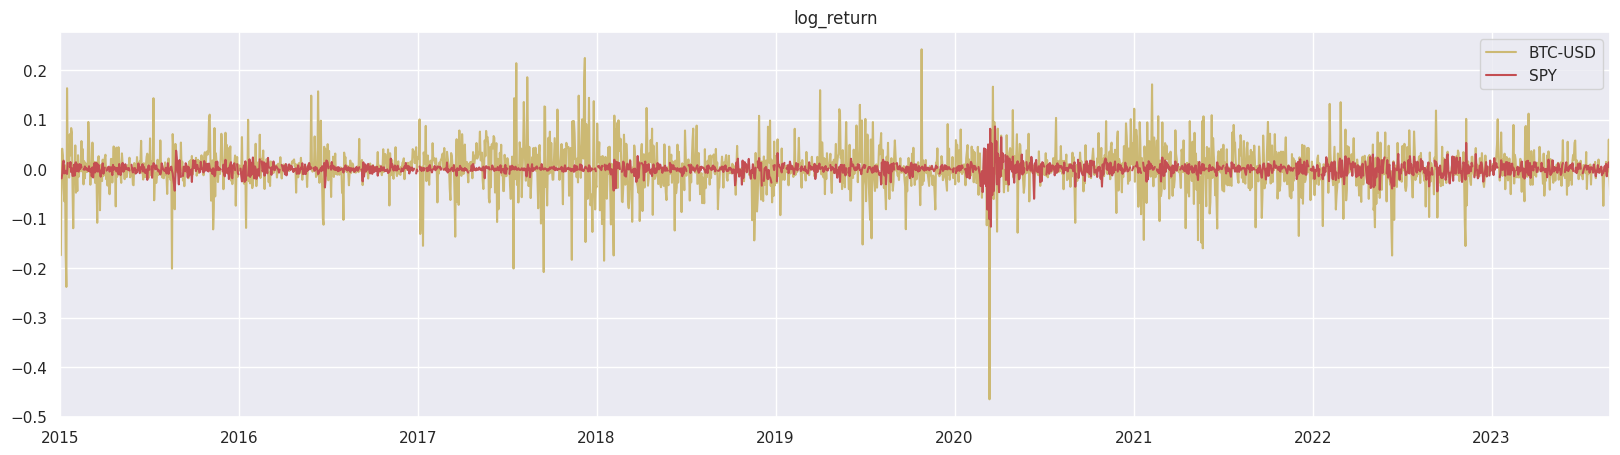

In [22]:
# Plot daily log returns.
log_return = np.log(resampled_adj_close).diff()
log_return.plot(title="log_return", color=color_dict)

In [23]:
# Note that the differences between percentage and log returns
#  significantly affect the SR, especially in the case of BTC.
pct_return.apply(costatis.compute_annualized_sharpe_ratio)

BTC-USD    1.075565
SPY        0.685646
dtype: float64

In [24]:
log_return.apply(costatis.compute_annualized_sharpe_ratio)

BTC-USD    0.713047
SPY        0.614981
dtype: float64

In [25]:
pct_return.apply(costatis.compute_annualized_return_and_volatility)

,BTC-USD,SPY
annualized_mean_return,0.763028,0.125268
annualized_volatility,0.709420,0.182701


In [26]:
# The methodology for return annualization is best suited to log
#  or dollar returns.
log_return.apply(costatis.compute_annualized_return_and_volatility)

,BTC-USD,SPY
annualized_mean_return,0.509177,0.110921
annualized_volatility,0.714085,0.180365


In [27]:
# Convert annualized log returns to percentage returns.
np.exp(log_return.apply(costatis.compute_annualized_return)) - 1

BTC-USD    0.663921
SPY        0.117307
dtype: float64

In [28]:
# Compute drawdown using log return and then convert to a percentage loss.
log_return.apply(costatis.compute_perc_loss_from_high_water_mark).max()

BTC-USD    0.830057
SPY        0.337173
dtype: float64

In [29]:
# The drawdown methodology applies directly to log and dollar returns.
#  Note that if log and percentage returns differ significantly (as is
#  the case with BTC), then the drawdown function may return nonsensical
#  results if incorrectly applied to percentage returns.
pct_return.apply(costatis.compute_drawdown).max()

BTC-USD    1.475519
SPY        0.381622
dtype: float64

In [30]:
dollar_return = resampled_adj_close.diff()

In [31]:
# Note that dollar return metrics differ meanginfully when the scale
#  of price changes dramatically over the calculation window (as is
#  the case with BTC).
dollar_return.apply(costatis.compute_annualized_sharpe_ratio)

BTC-USD    0.194419
SPY        0.623918
dtype: float64

In [32]:
dollar_return.apply(costatis.compute_annualized_return_and_volatility)

,BTC-USD,SPY
annualized_mean_return,2955.724557,33.829800
annualized_volatility,15202.850290,54.221512


In [33]:
resampled_adj_close.mean()

BTC-USD    14325.471175
SPY          288.187427
dtype: float64

In [34]:
dollar_return.apply(costatis.compute_drawdown).max()

BTC-USD    51779.543945
SPY          107.556427
dtype: float64

<Axes: >

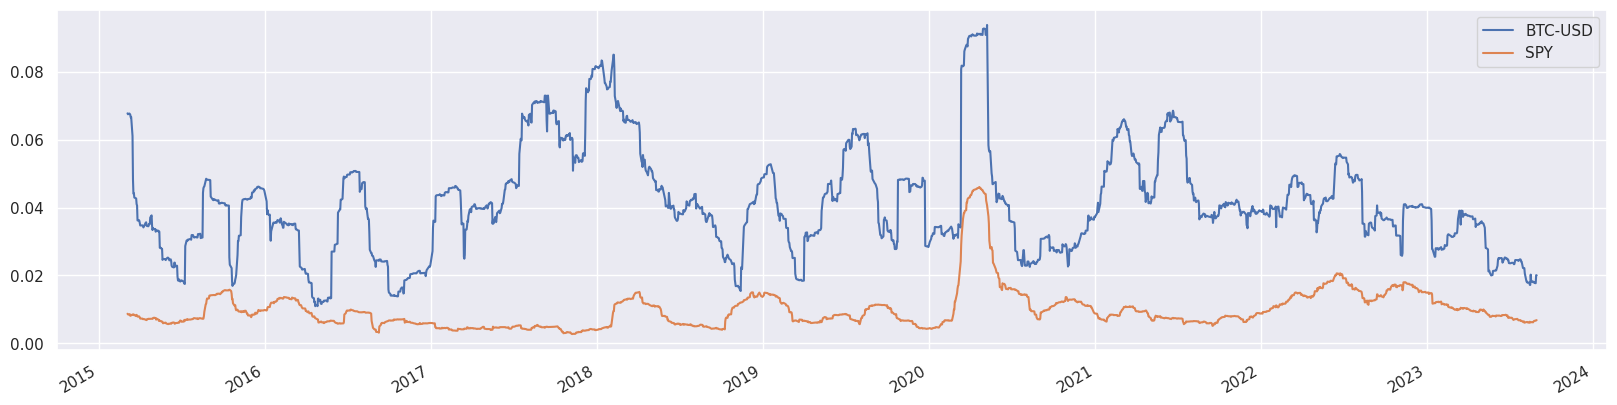

In [35]:
# Rolling volatility differences due to using log vs percentage returns are much less
#  pronounced, even in the case of a highly volatilite asset like BTC.
np.sqrt((log_return**2).dropna().rolling(num_points_rolling_vol).mean()).plot()

<Axes: >

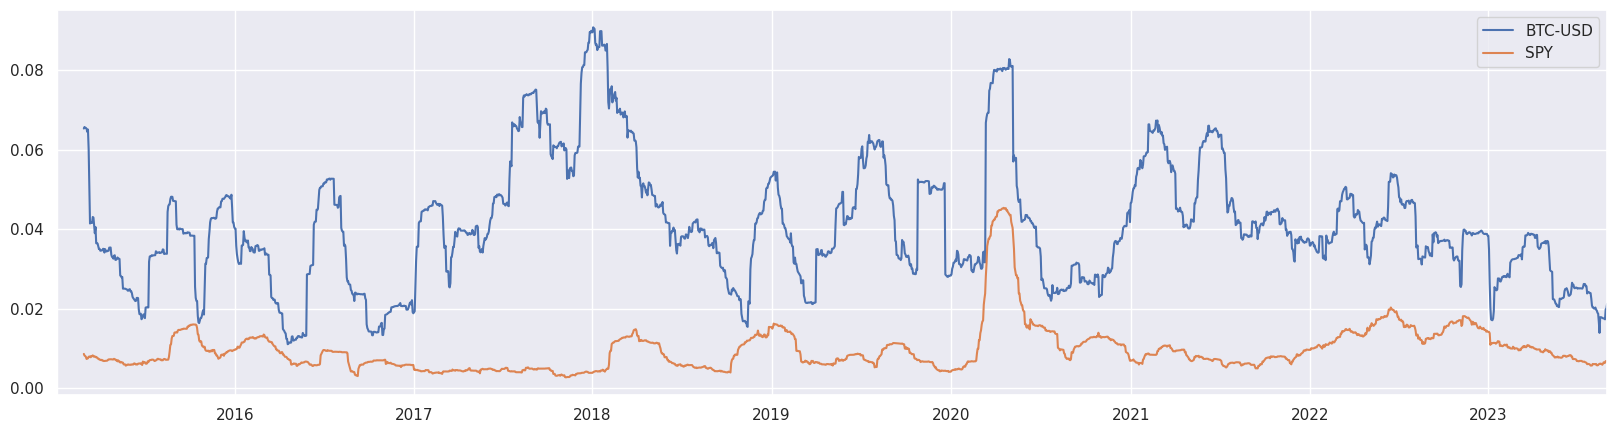

In [36]:
np.sqrt((pct_return**2).dropna().rolling(num_points_rolling_vol).mean()).plot()

<Axes: title={'center': 'volatlity'}, xlabel='date', ylabel='% daily volatility'>

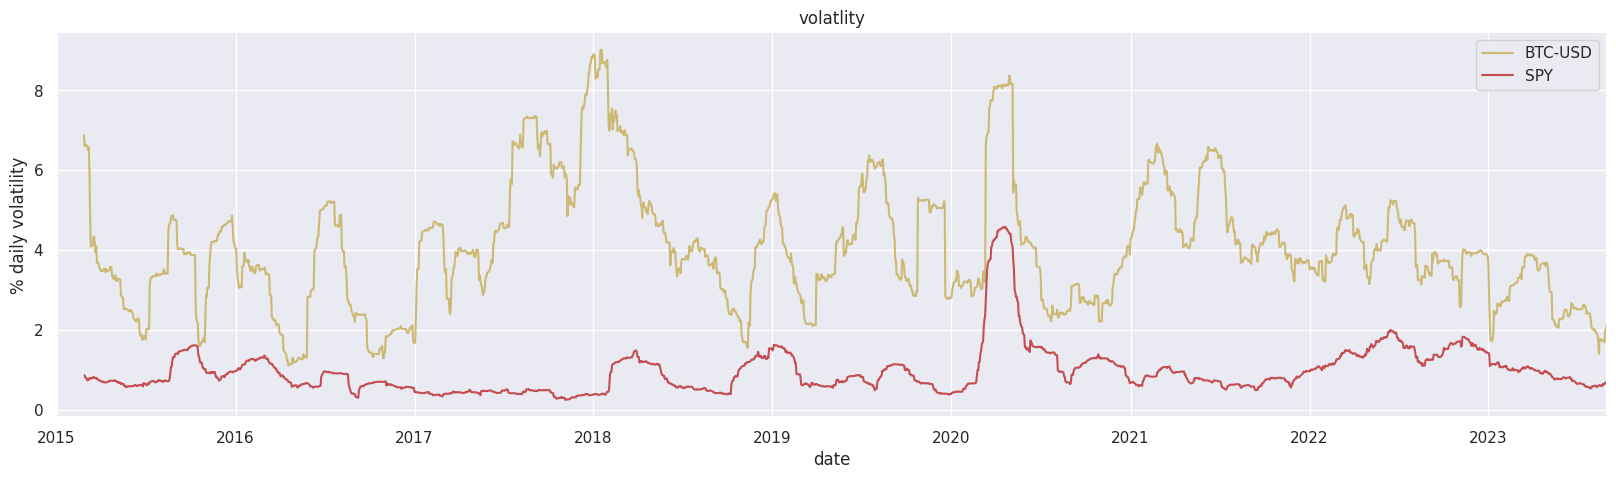

In [37]:
# Compute daily volatility in percentage terms using percentage return.
#  On these scales, the difference between using `std()` vs an estimator
#  that assumes zero mean is negligible.
vol = pct_return.rolling(num_points_rolling_vol).std()
(100 * vol).plot(
    title="volatlity",
    ylabel="% daily volatility",
    xlabel="date",
    color=color_dict
)

<Axes: title={'center': 'volatility-adjusted return'}, xlabel='date', ylabel='standard deviations'>

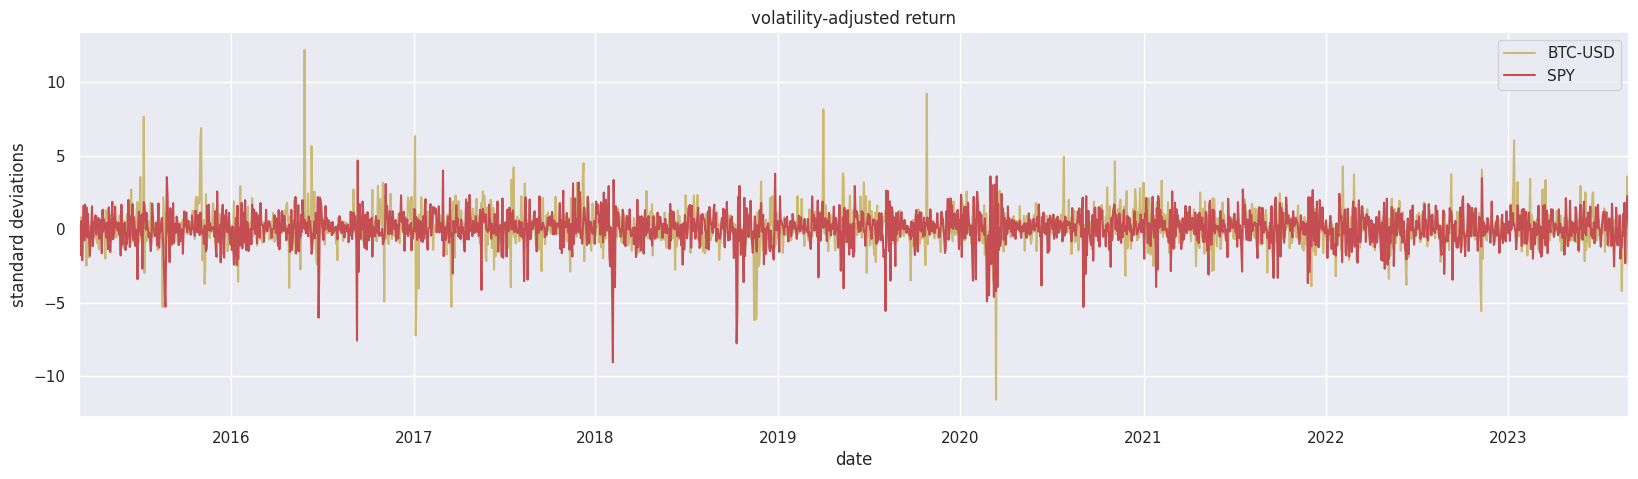

In [38]:
# Compute volatility-adjusted returns from percentage returns.
adj_rets = pct_return.divide(vol.shift(2)).dropna(how="all").iloc[1:]
adj_rets.plot(
    title="volatility-adjusted return",
    ylabel="standard deviations",
    xlabel="date",
    color=color_dict,
)

,BTC-USD,SPY
BTC-USD,1.000000,0.172133
SPY,0.172133,1.000000


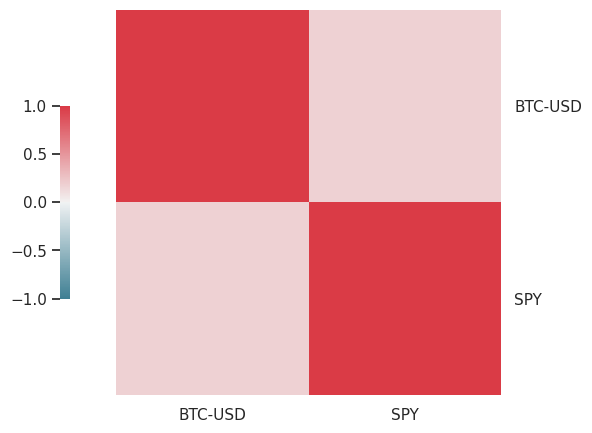

In [39]:
# Use volatility-adjusted returns (from percentage returns) to
#  calculate correlation.
coplotti.plot_correlation_matrix(adj_rets)

In [40]:
# Note that SR boost achieved from vol-targeting.
adj_rets.apply(costatis.compute_annualized_sharpe_ratio)

BTC-USD    1.252769
SPY        0.742649
dtype: float64

In [41]:
# These need to be rescaled.
adj_rets.apply(costatis.compute_annualized_return_and_volatility)

,BTC-USD,SPY
annualized_mean_return,24.258183,13.612329
annualized_volatility,19.363645,18.329418


# Equally-weighted returns

In [42]:
sim_start_date = "2016-01-01"

In [43]:
equally_weighted_pct_return = pct_return.mean(axis=1).rename("equally_weighted_pct_return").loc[sim_start_date:]

In [44]:
equally_weighted_log_return = np.log(1 + equally_weighted_pct_return).rename("equally_weighted_log_return")

<Axes: title={'center': '50% SPY-50% BTC Blend'}, xlabel='date', ylabel='return multiple'>

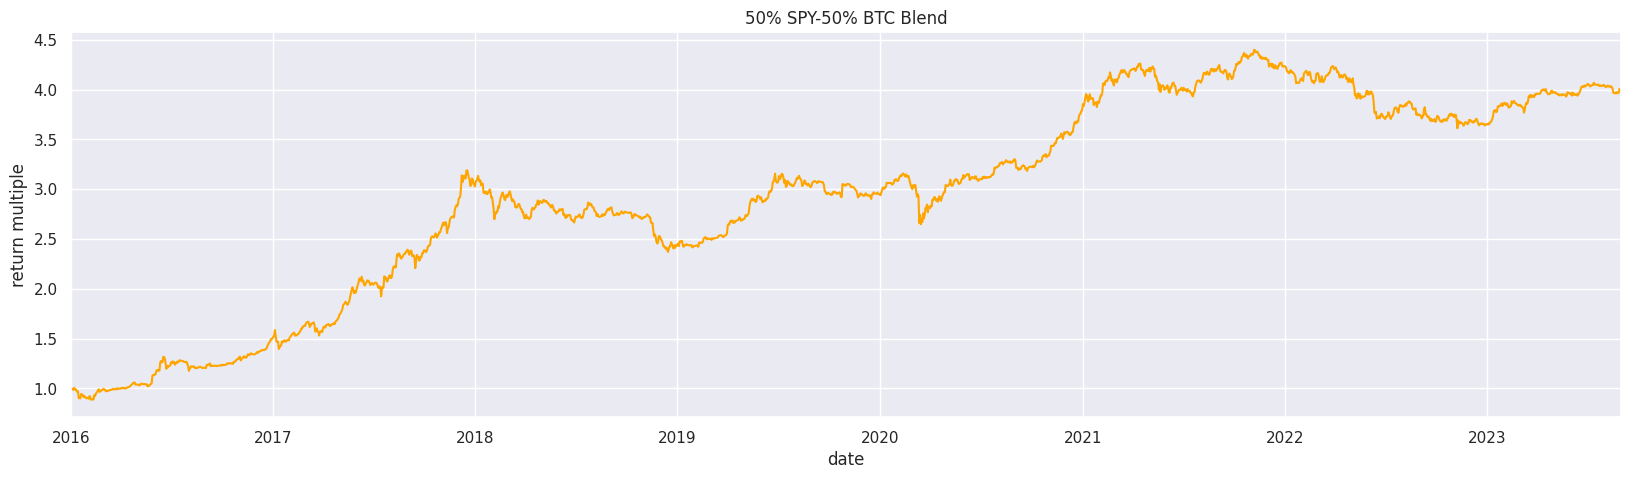

In [45]:
(1 + equally_weighted_log_return.cumsum()).plot(
    title="50% SPY-50% BTC Blend",
    ylabel="return multiple",
    xlabel="date",
    color="orange",
)

In [46]:
costatis.compute_annualized_sharpe_ratio(equally_weighted_log_return)

0.9940917984113521

In [47]:
costatis.compute_annualized_return_and_volatility(equally_weighted_log_return)

annualized_mean_return    0.388168
annualized_volatility     0.390475
Name: equally_weighted_log_return, dtype: float64

In [48]:
costatis.compute_perc_loss_from_high_water_mark(equally_weighted_log_return).max()

0.5594455845062112

# Equal risk-weighted returns

<Axes: >

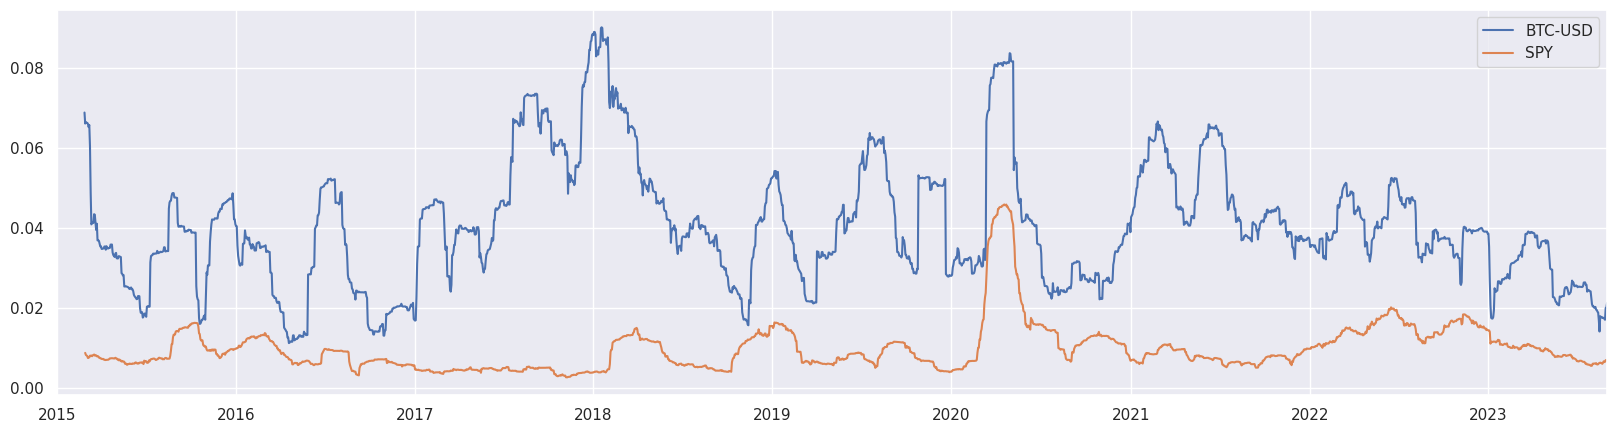

In [49]:
vol.plot()

In [50]:
risk_weighted_pnl = adj_rets.mean(axis=1).rename("risk_weighted_pnl")

<Axes: >

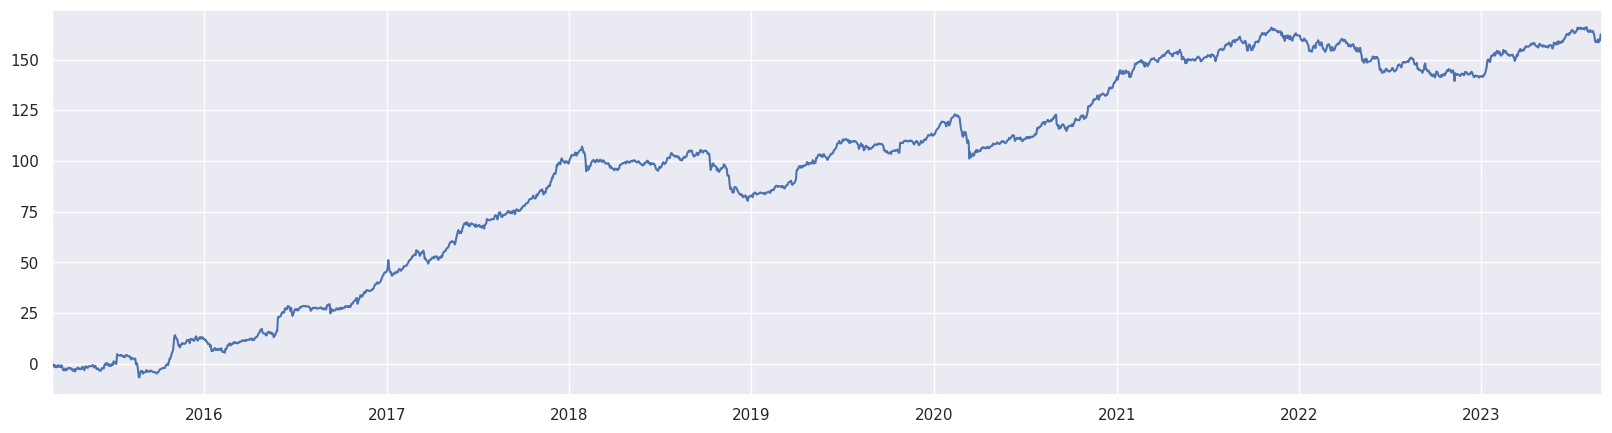

In [51]:
risk_weighted_pnl.cumsum().plot()

In [52]:
costatis.compute_annualized_sharpe_ratio(risk_weighted_pnl)

1.3120515104093746

In [53]:
# These have to be properly rescaled.
costatis.compute_annualized_return_and_volatility(risk_weighted_pnl)

annualized_mean_return    18.935256
annualized_volatility     14.431793
Name: risk_weighted_pnl, dtype: float64

In [54]:
# This is meaningless without the correct rescaling.
costatis.compute_perc_loss_from_high_water_mark(risk_weighted_pnl).max()

0.9999999999976743

In [55]:
relative_allocation = (1/vol)#.divide((1/vol).sum(axis=1), axis=0)

In [56]:
scale_factor = 1/200

<Axes: >

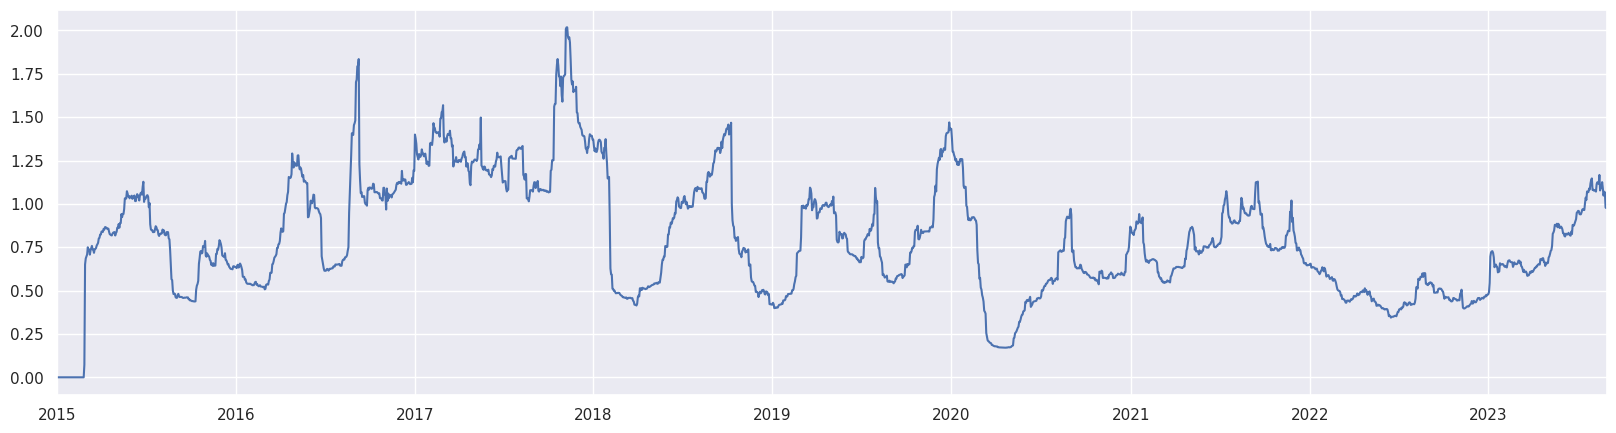

In [57]:
(scale_factor * relative_allocation).sum(axis=1).plot()

In [58]:
risk_weighted_pct_return = (scale_factor * relative_allocation * pct_return.shift(-2)).mean(axis=1)

In [59]:
costatis.compute_annualized_return_and_volatility(risk_weighted_pct_return)

annualized_mean_return    0.093374
annualized_volatility     0.071486
dtype: float64

In [60]:
risk_weighted_log_return = np.log(1 + risk_weighted_pct_return)

In [61]:
costatis.compute_annualized_sharpe_ratio(risk_weighted_log_return)

1.2690474893672565

In [62]:
costatis.compute_annualized_return_and_volatility(risk_weighted_log_return)

annualized_mean_return    0.090801
annualized_volatility     0.071550
dtype: float64

In [63]:
costatis.compute_perc_loss_from_high_water_mark(risk_weighted_log_return).max()

0.1277162490104471

# Inverse covariance

## Whole-period estimate

In [64]:
#corr = adj_rets.loc[:sim_start_date].corr()
corr = adj_rets.corr()
inv_corr = csigproc.compute_inverse(corr)
corr_adj_rets = (adj_rets @ inv_corr).mean(axis=1)

In [65]:
costatis.compute_annualized_sharpe_ratio(corr_adj_rets)

1.3120515104093748

<Axes: >

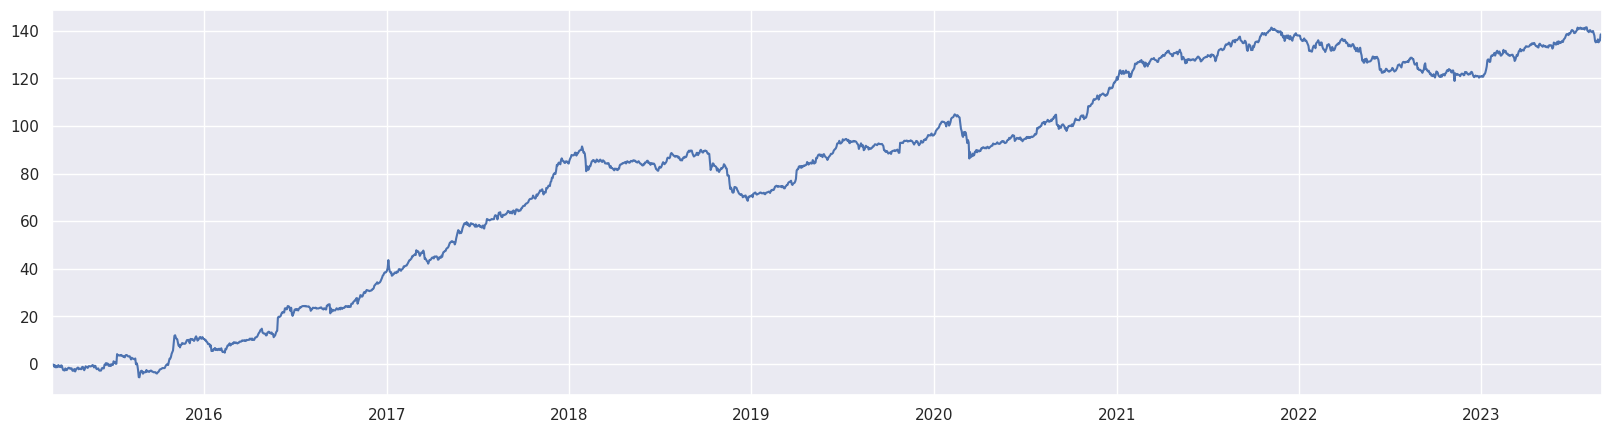

In [66]:
corr_adj_rets.cumsum().plot()

## Rolling estimate

In [67]:
corrs = adj_rets.rolling(num_points_rolling_vol).corr()
datetimes = corrs.index.levels[0]

In [68]:
inv_corrs = {}
target_pos = {}
for datetime in datetimes:
    corr = corrs.loc[datetime]
    if not corr.dropna().empty:
        inv_corr = csigproc.compute_inverse(corr)
        inv_corrs[datetime] = inv_corr
        pos = inv_corr.sum()
        pos.name = datetime
        target_pos[datetime] = pos

<Axes: >

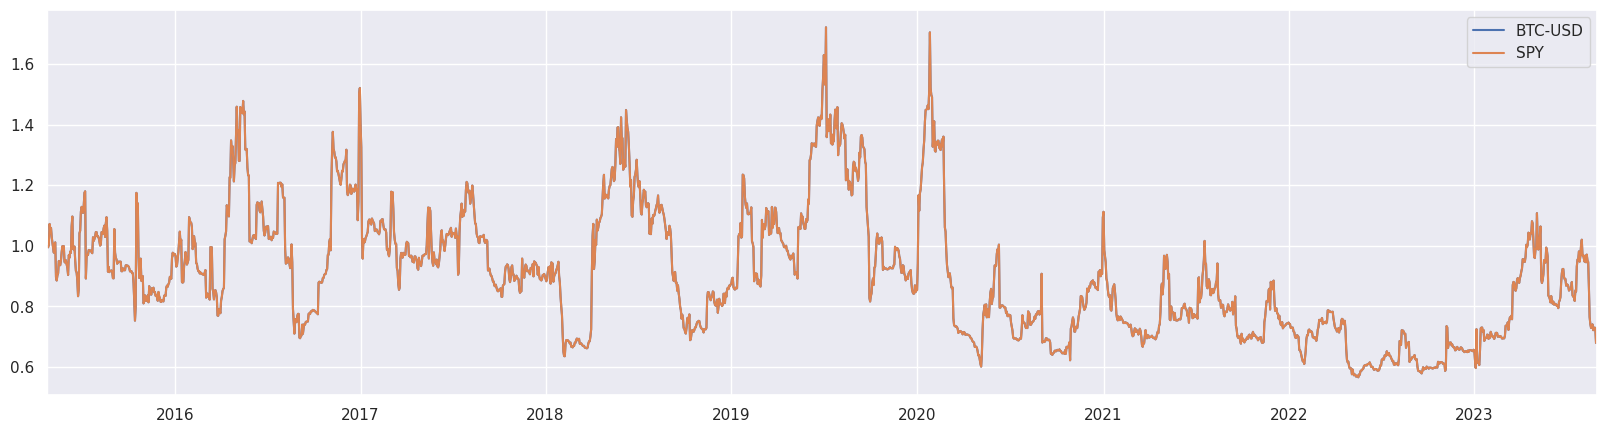

In [69]:
# Target positions in volatility-adjusted instruments.
target_pos_df = pd.DataFrame(target_pos).T
target_pos_df.plot()

In [70]:
# Does not reflect % in cash. 
unscaled_target_pos_df = (target_pos_df / vol).divide((target_pos_df / vol).abs().sum(axis=1), axis=0)

<Axes: title={'center': 'Percentage allocation in dynamic SPY-BTC blend'}, xlabel='date', ylabel='% allocation'>

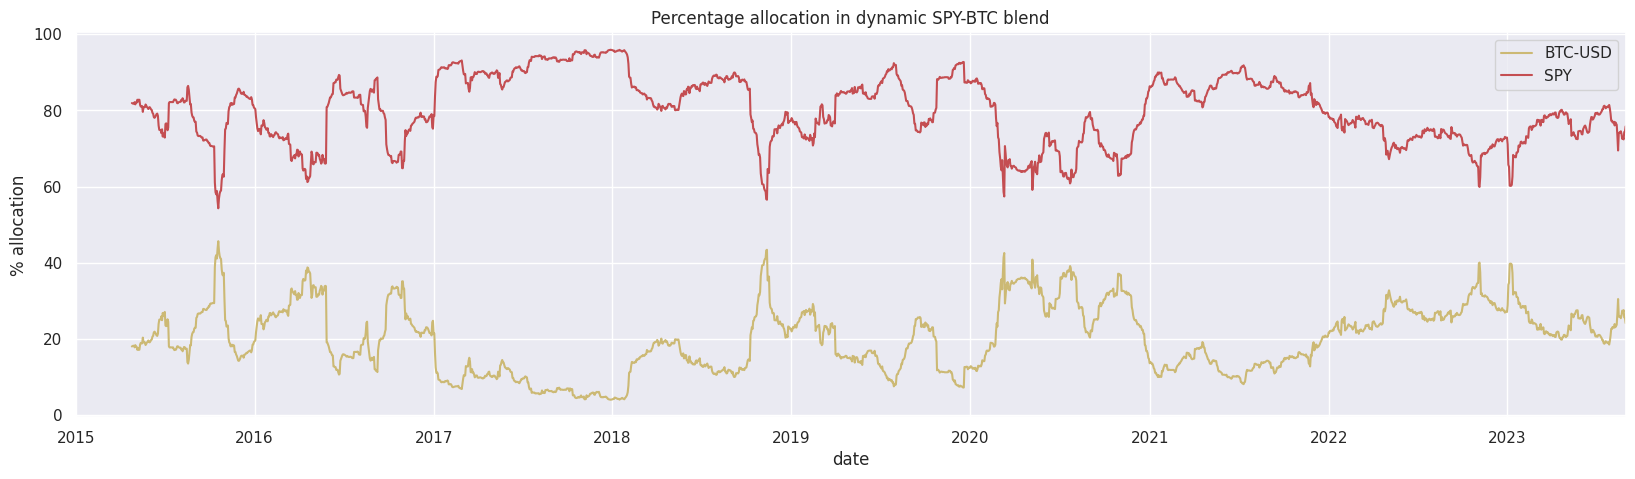

In [71]:
(100 * unscaled_target_pos_df).plot(
    title="Percentage allocation in dynamic SPY-BTC blend",
    ylabel="% allocation",
    xlabel="date",
    color=color_dict,
)

In [72]:
rp_pnl = (target_pos_df * adj_rets.shift(-2)).mean(axis=1)

In [73]:
costatis.compute_annualized_sharpe_ratio(rp_pnl)

1.443017672713717

<Axes: >

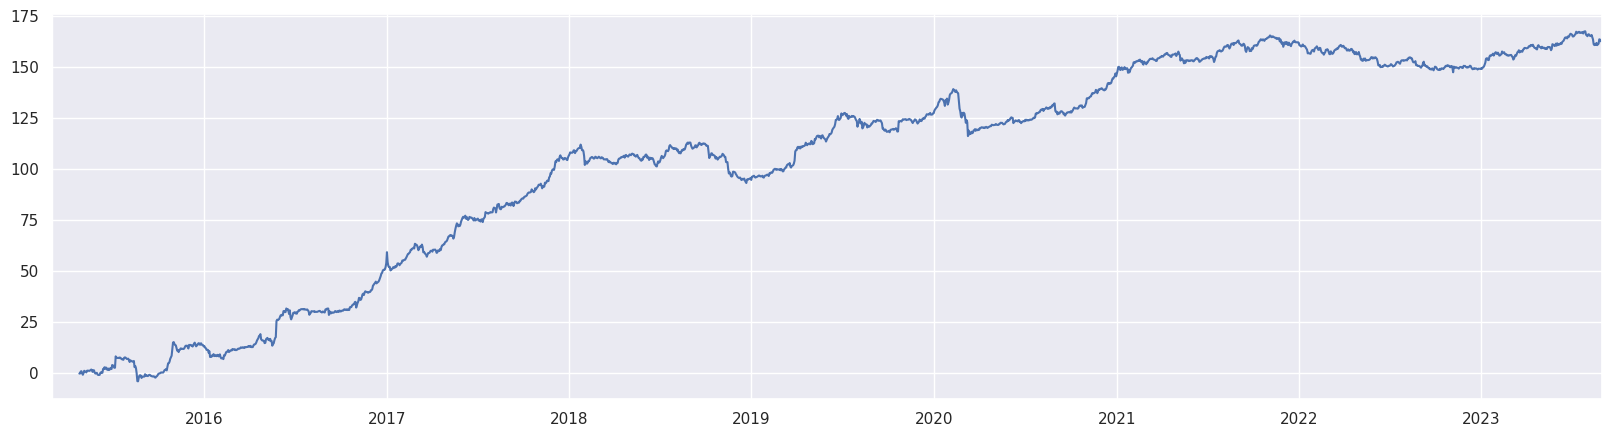

In [74]:
rp_pnl.cumsum().plot()

In [75]:
pnl_dict = {}
for idx in adj_rets.shift(-2).index:
    if idx in inv_corrs:
        pnl = (inv_corrs[idx] @ adj_rets.shift(-2).loc[idx]).mean()
        pnl_dict[idx] = pnl
    else:
        _LOG.debug("Skipping idx=%s", idx)
rolling_pnl = pd.Series(pnl_dict).shift(2).rename("risk_parity_pnl")

In [76]:
costatis.compute_annualized_sharpe_ratio(rolling_pnl)

1.4559722279694214

<Axes: >

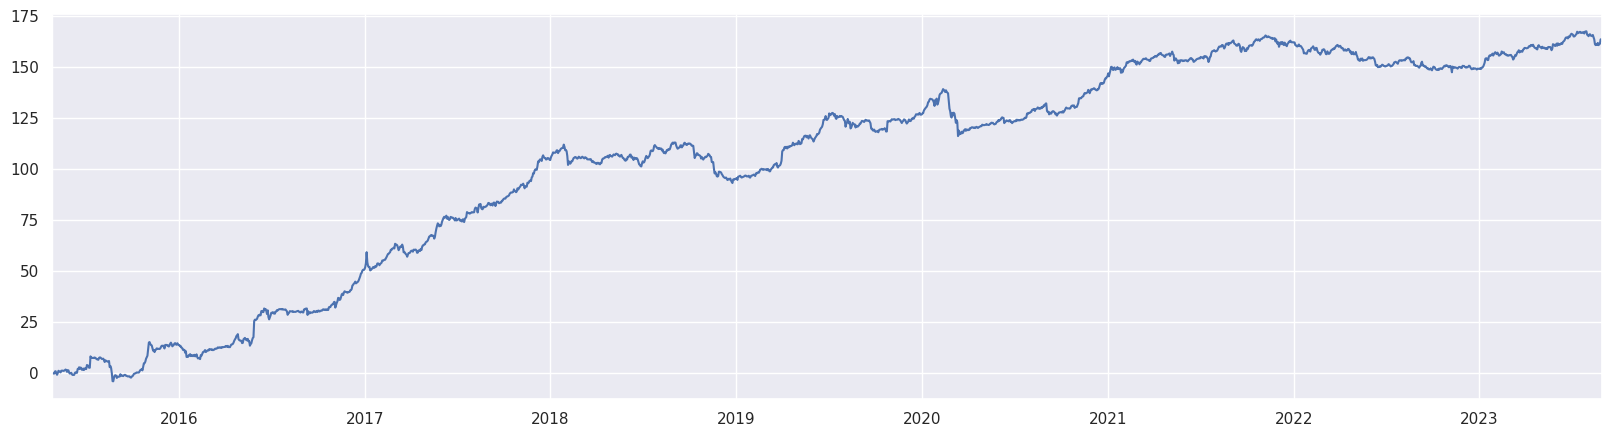

In [77]:
rolling_pnl.cumsum().plot()

In [78]:
lev1 = np.log(1 + 0.01 * rolling_pnl)
lev2 = 2 * np.log(1 + 0.01 * rolling_pnl)

In [79]:
costatis.compute_annualized_sharpe_ratio(lev1)

1.3889391289655746

In [80]:
costatis.compute_annualized_return_and_volatility(lev1)

annualized_mean_return    0.185683
annualized_volatility     0.133687
Name: risk_parity_pnl, dtype: float64

In [81]:
costatis.compute_annualized_return_and_volatility(lev2)

annualized_mean_return    0.371365
annualized_volatility     0.267373
Name: risk_parity_pnl, dtype: float64

In [82]:
costatis.compute_perc_loss_from_high_water_mark(lev1).max()

0.2099567469040695

In [83]:
costatis.compute_perc_loss_from_high_water_mark(lev2).max()

0.37583165823759956

In [84]:
# Maybe we revive the "Universal Portfolio" approach of Thomas Cover.

In [85]:
pnls = [
    log_return,
    equally_weighted_log_return.rename("50% SPY-50% BTC"),
    lev1.rename("Kaizen 1x leverage"),
    lev2.rename("Kaizen 2x leverage"),
]

In [86]:
pnl_df = pd.concat(pnls, axis=1).loc[sim_start_date:]

<Axes: title={'center': 'BTC-SPY Blends'}, xlabel='date', ylabel='return multiple'>

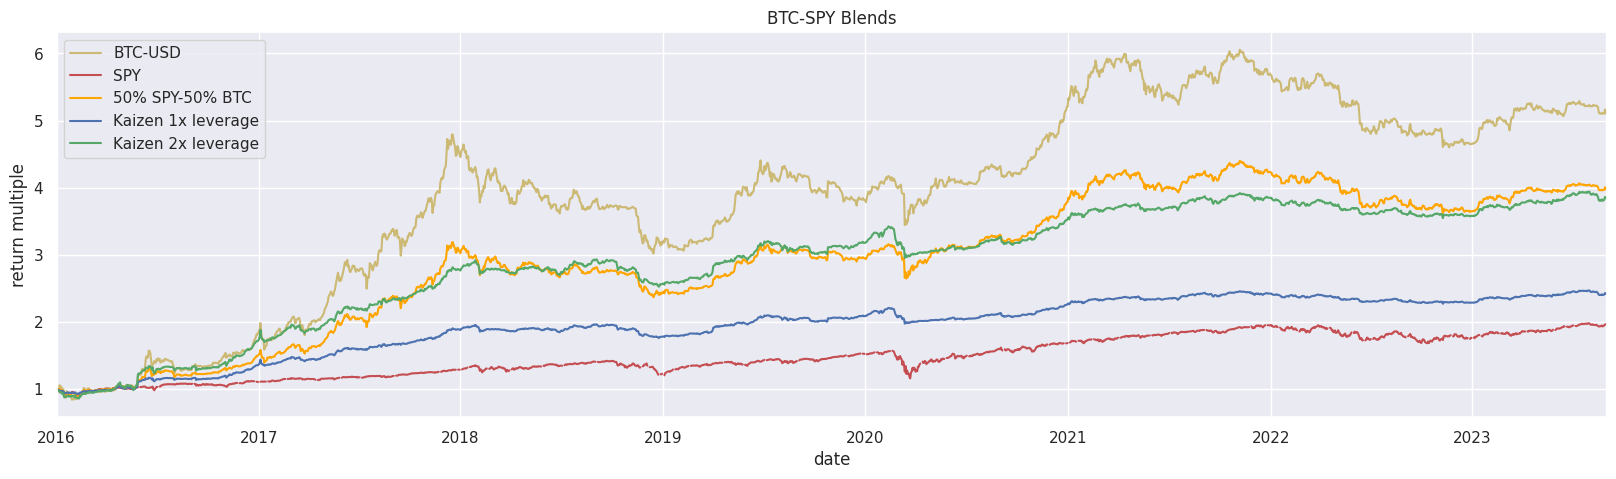

In [87]:
(1 + pnl_df.loc[sim_start_date:].cumsum()).plot(
    title="BTC-SPY Blends",
    ylabel="return multiple",
    xlabel="date",
    color={
        "SPY": "r",
        "BTC-USD": "y",
        "50% SPY-50% BTC": "orange",
        "Kaizen 1x leverage": "b",
        "Kaizen 2x leverage": "g",
    },
)

<Axes: title={'center': 'BTC-SPY Blends'}, xlabel='date', ylabel='return multiple'>

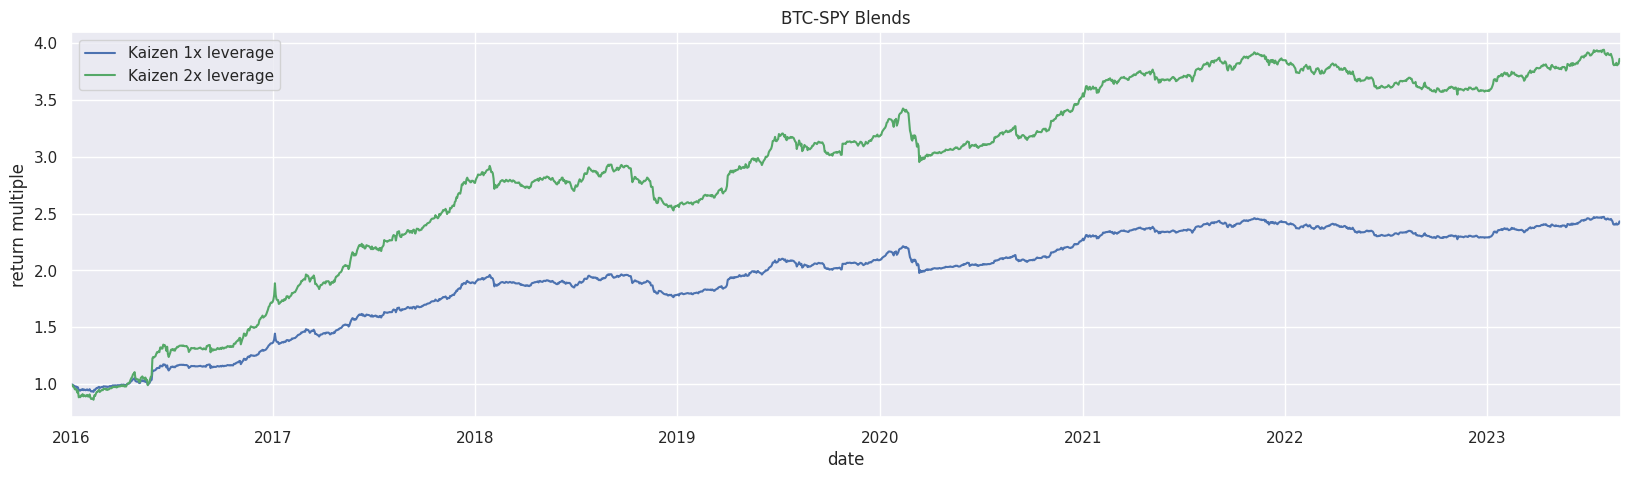

In [88]:
(1 + pnl_df.loc[sim_start_date:][["Kaizen 1x leverage", "Kaizen 2x leverage"]].cumsum()).plot(
    title="BTC-SPY Blends",
    ylabel="return multiple",
    xlabel="date",
    color={
        "SPY": "r",
        "BTC-USD": "y",
        "50% SPY-50% BTC": "orange",
        "Kaizen 1x leverage": "b",
        "Kaizen 2x leverage": "g",
    },
)

In [89]:
pnl_df.apply(costatis.compute_annualized_sharpe_ratio)

BTC-USD               0.746081
SPY                   0.687759
50% SPY-50% BTC       0.994092
Kaizen 1x leverage    1.400870
Kaizen 2x leverage    1.400870
dtype: float64

<Axes: title={'center': 'BTC-SPY Blends'}, xlabel='date', ylabel='standardized returns'>

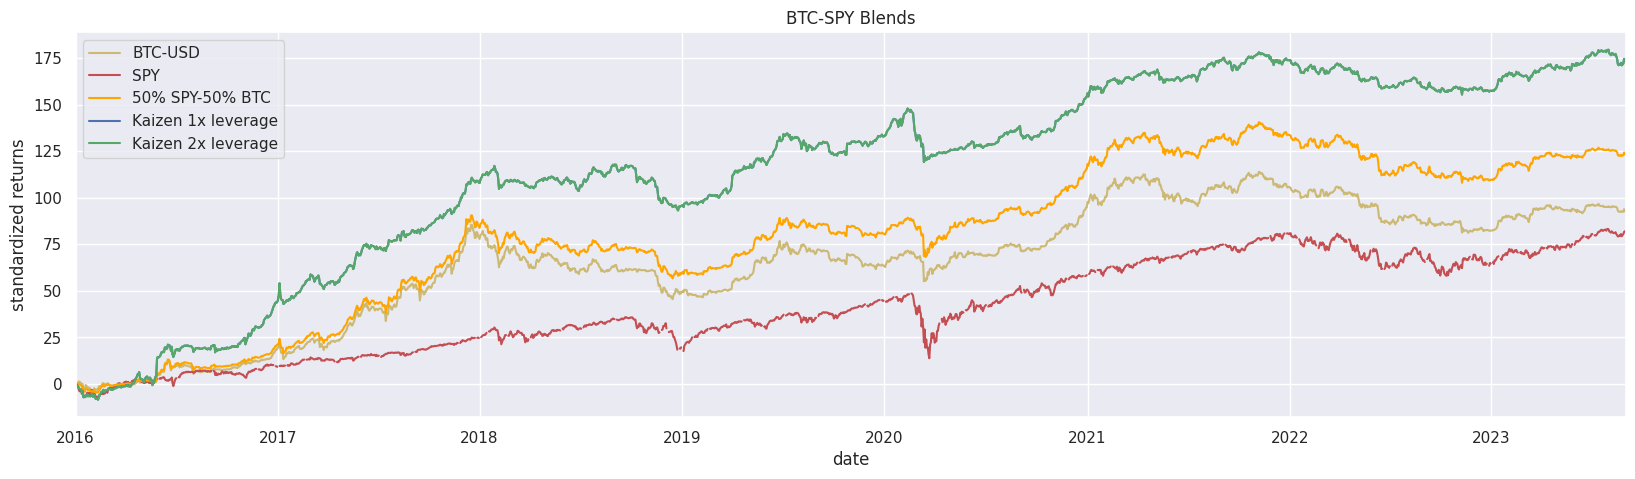

In [90]:
(pnl_df / pnl_df.std()).cumsum().plot(
    title="BTC-SPY Blends",
    ylabel="standardized returns",
    xlabel="date",
    color={
        "SPY": "r",
        "BTC-USD": "y",
        "50% SPY-50% BTC": "orange",
        "Kaizen 1x leverage": "b",
        "Kaizen 2x leverage": "g",
    },
)